In [1]:
library(SILGGM)
library(patchwork)
library(latex2exp)

rm(list = ls())
set.seed(0)
source('../tools.R')
source('../FLAG.R')

Loading required package: Rcpp


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [2]:
generate.precision <- function(pi=0.15){
  k=0
  while(T){
    k=k+1

    Pre = matrix(0.15 * rbinom(P*P, 1, pi), nrow = P, ncol = P)
    Pre[lower.tri(Pre)] = t(Pre)[lower.tri(Pre)]
    diag(Pre) = 1

    vals <- eigen(Pre)$values

    if(is.complex(vals) ) next
    if(all(vals>0.01)) {

      break
    }
    if(k>1000) break
  }
  cat('pi=', pi, 'generated in the',k,' times\n')
  Pre
}

In [3]:
# pi.list = c(0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7)
pi.list = c(0.15, 0.3, 0.6, 0.7)
pi.len = length(pi.list)
fdr.list = c(0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3)
fdr.len = length(fdr.list)
P = 50
N = 300

rep.times = 100
result.list = list()
for(pi.idx in 1:pi.len){
  pi = pi.list[pi.idx]
  Pre = generate.precision(pi)
  Sigma = solve(Pre)
  Pre.adj = get.adj(Pre)
  
  fdr = NULL
  for(rep in 1:rep.times){
    Z = MASS::mvrnorm(N, rep(0, P), Sigma)
    Z = scale(Z, center = T, scale = F)

    OM = OurMethod(Z)
    ANT = run.ant(Z)
    gfc = SILGGM(Z, method='GFC_L', alpha=fdr.list, ndelta=10, global=TRUE)

    fdr.om = c()
    fdr.ant = c()
    fdr.gfc = c()
    for(fdr.idx in 1:fdr.len){
      fdr.thr = fdr.list[fdr.idx]

      om.adj = get.fdr(OM$precision.pval, thr = fdr.thr)
      om.fdr = sum( get.tri(om.adj) * (1- get.tri(Pre.adj) ) ) / sum( get.tri(om.adj) )
      fdr.om = c(fdr.om, om.fdr)

      ant.adj = get.fdr(ANT$p_precision, thr = fdr.thr)
      ant.fdr = sum( get.tri(ant.adj) * (1- get.tri(Pre.adj) ) ) / sum( get.tri(ant.adj) )
      fdr.ant = c(fdr.ant, ant.fdr)

      gfc.fdr = sum( get.tri(gfc$global_decision[[fdr.idx]]) * (1- get.tri(Pre.adj) ) ) / sum( get.tri(gfc$global_decision[[fdr.idx]]) )
      fdr.gfc = c(fdr.gfc, gfc.fdr)
    }
    fdr0 = data.frame( c(fdr.om, fdr.ant, fdr.gfc) )
    fdr = rbind(fdr, t(fdr0))
  }
  colnames(fdr) = c("om.01", "om.02", "om.05", "om.1", "om.15", "om.2", "om.25", "om.3",
                    "ant.01", "ant.02", "ant.05", "ant.1", "ant.15", "ant.2", "ant.25", "ant.3",
                    "gfc.01", "gfc.02", "gfc.05", "gfc.1", "gfc.15", "gfc.2", "gfc.25", "gfc.3")
  fdr[is.na(fdr)] = 0
  
  result.list[[pi.idx]] = fdr
}

pi= 0.15 generated in the 1  times
Use method '"GFC_L"'
Center each column.
Standardize each column.
Pre-calculate inner product matrixes.
In this case, number of delta = 10
Perform global inference.
Use pre-specified level(s): 0.01 0.02 0.05 0.1 0.15 0.2 0.25 0.3
True graph is not available.
Calculate Lasso of each variable with tuning parameters under each delta.
Record test statistics under each delta.
delta 1
Lasso for variable 1
delta 2
Lasso for variable 1
delta 3
Lasso for variable 1
delta 4
Lasso for variable 1
delta 5
Lasso for variable 1
delta 6
Lasso for variable 1
delta 7
Lasso for variable 1
delta 8
Lasso for variable 1
delta 9
Lasso for variable 1
delta 10
Lasso for variable 1
Choose delta for FDR control.
Use method '"GFC_L"'
Center each column.
Standardize each column.
Pre-calculate inner product matrixes.
In this case, number of delta = 10
Perform global inference.
Use pre-specified level(s): 0.01 0.02 0.05 0.1 0.15 0.2 0.25 0.3
True graph is not available.
Calculate L

In [9]:
fdr.scatter <- function(pi.idx, bound=0.34){
  fdr.means = colMeans(result.list[[pi.idx]])
  fdr.om = c(fdr.means['om.01'], fdr.means['om.02'], fdr.means['om.05'], fdr.means['om.1'], fdr.means['om.15'], fdr.means['om.2'], fdr.means['om.25'], fdr.means['om.3'])
  fdr.ant = c(fdr.means['ant.01'], fdr.means['ant.02'], fdr.means['ant.05'], fdr.means['ant.1'], fdr.means['ant.15'], fdr.means['ant.2'], fdr.means['ant.25'], fdr.means['ant.3'])
  fdr.gfc = c(fdr.means['gfc.01'], fdr.means['gfc.02'], fdr.means['gfc.05'], fdr.means['gfc.1'], fdr.means['gfc.15'], fdr.means['gfc.2'], fdr.means['gfc.25'], fdr.means['gfc.3'])
  df = data.frame(X=c(fdr.list, fdr.list, fdr.list), Y = c(fdr.gfc, fdr.ant, fdr.om), 
                    method=c(rep('GFC', fdr.len), rep('ANT', fdr.len), rep('FLAG', fdr.len)))
  df$method = factor(df$method, levels=c('GFC', 'ANT', 'FLAG'))
  ggplot(df, aes(x=X, y=Y, color=method)) +
    geom_point(size=3) + geom_abline(intercept = 0, slope = 1, color='black')+ coord_fixed() +
    scale_x_continuous(limits=c(0, bound))+scale_y_continuous(limits=c(0, bound))+ scale_color_manual(values=c("#E69F00", "#00BFC4", "#FF6666")) +
#     ggtitle( TeX(paste0("Nonzero proportion ", r"($\pi$)", '=', pi.list[pi.idx]) )) +xlab('Controlled')+ylab('Actual') +
    ggtitle( TeX(paste0(r"($\pi$)", ' = ', pi.list[pi.idx]) )) +xlab('Controlled')+ylab('Actual') +
    theme(text = element_text(size = 18), axis.text = element_text(size = 16), legend.text = element_text(size = 18))
}

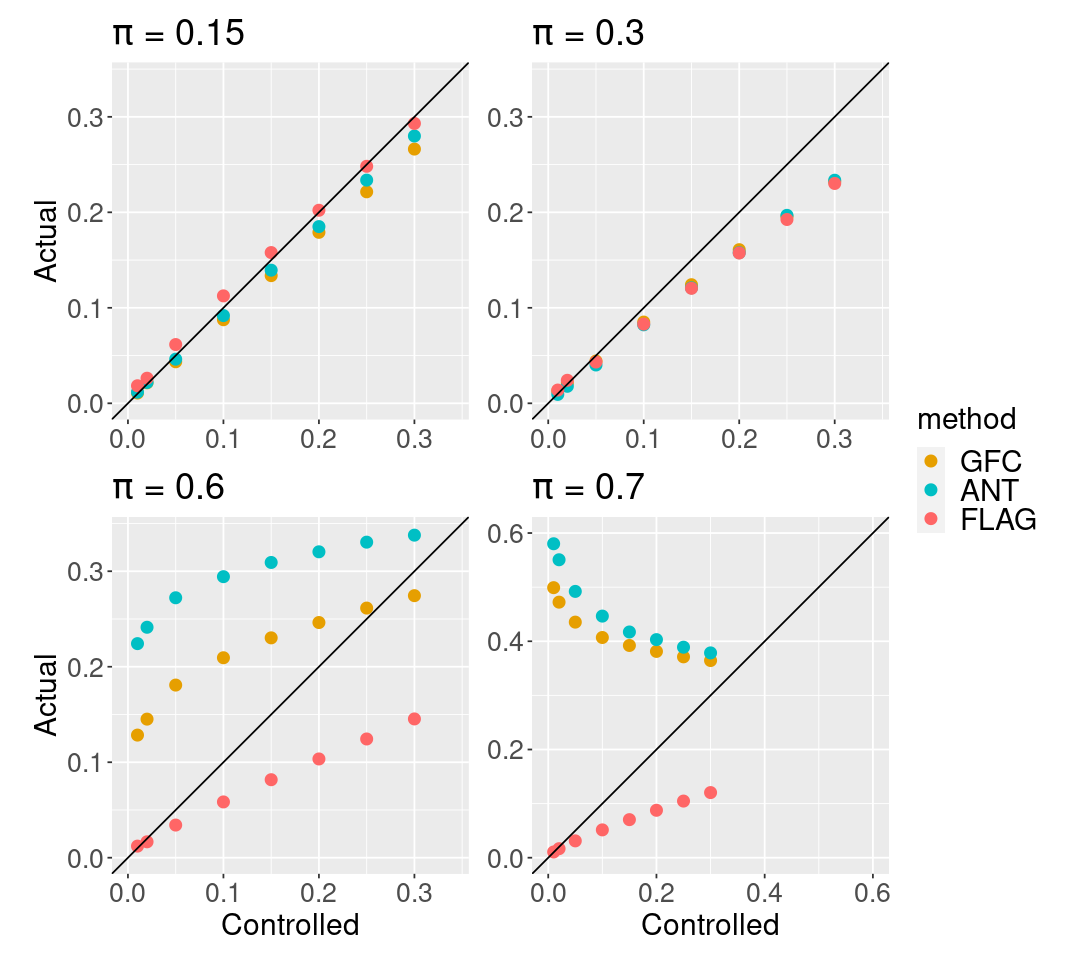

In [10]:
options(repr.plot.width=9, repr.plot.height=8)

fdr.scatter(1) + xlab(NULL) +
fdr.scatter(2) + xlab(NULL) + ylab(NULL) +
fdr.scatter(3) +
fdr.scatter(4, bound=0.6) + ylab(NULL) +
plot_layout(nrow=2, guides = "collect")